In [1]:
from pynq import allocate
from pynq import Overlay
import numpy as np

overlay = Overlay('systolic.bit')

/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/ps.py:434: UserWarning: Setting frequency to the closest possible value 98.8879MHz.
  warnings.warn(


In [49]:
from pynq import Clocks
Clocks.fclk0_mhz = 300
print(f'CPU:   {Clocks.cpu_mhz:.6f}MHz')
print(f'FCLK0: {Clocks.fclk0_mhz:.6f}MHz')
#print(f'FCLK1: {Clocks.fclk1_mhz:.6f}MHz')
#print(f'FCLK2: {Clocks.fclk2_mhz:.6f}MHz')
#print(f'FCLK3: {Clocks.fclk3_mhz:.6f}MHz')

CPU:   1199.988000MHz
FCLK0: 296.663700MHz


In [4]:
def alu(data):
    in_buffer  = allocate(shape=(np.size(data),), dtype=np.int64)
    out_buffer = allocate(shape=(np.size(data)-3,), dtype=np.int64)
    np.copyto(in_buffer, data)
    in_buffer.sync_to_device()
    overlay.axi_dma_0.recvchannel.transfer(out_buffer)
    overlay.axi_dma_0.sendchannel.transfer(in_buffer)
    overlay.axi_dma_0.sendchannel.wait()
    overlay.axi_dma_0.recvchannel.wait()
    out_buffer.sync_from_device()
    return out_buffer

In [5]:
def interleave_with_one(xx, yy, zz, one=1):
    if not (len(xx) == len(yy) == len(zz)):
        raise ValueError("xx/yy/zz 長度必須一致")
    n = len(xx)
    out = [None] * (4 * n)
    out[0::4] = xx
    out[1::4] = yy
    out[2::4] = zz
    out[3::4] = [one] * n
    return np.array(out)

def split_int64_to_int16_view(x64):
    arr = np.asarray(x64, dtype=np.int64)
    arr = np.atleast_1d(arr)
    chunks = arr.view('<i2').reshape(-1, 4)
    return chunks

In [95]:
ran = 1000
res = 100
xx = np.arange(ran / res / 2, ran, ran / res)
yy = np.arange(ran / res / 2, ran, ran / res)
zz = np.arange(ran / res / 2, ran, ran / res)
SCALE = 41
X0    = -20480
Y0    = -16384
Z0    = -17612

In [96]:
S = np.eye(3,dtype=np.uint16)*SCALE
T = np.array([[X0], [Y0], [Z0]])
SRT = np.hstack([S, T])
SRT = SRT.ravel()

In [97]:
vector = interleave_with_one(xx, yy, zz)
input_array = np.concatenate((SRT, vector))

In [121]:
input_array

array([ 4.1000e+01,  0.0000e+00,  0.0000e+00, -2.0480e+04,  0.0000e+00,
        4.1000e+01,  0.0000e+00, -1.6384e+04,  0.0000e+00,  0.0000e+00,
        4.1000e+01, -1.7612e+04,  5.0000e+00,  5.0000e+00,  5.0000e+00,
        1.0000e+00,  1.5000e+01,  1.5000e+01,  1.5000e+01,  1.0000e+00,
        2.5000e+01,  2.5000e+01,  2.5000e+01,  1.0000e+00,  3.5000e+01,
        3.5000e+01,  3.5000e+01,  1.0000e+00,  4.5000e+01,  4.5000e+01,
        4.5000e+01,  1.0000e+00,  5.5000e+01,  5.5000e+01,  5.5000e+01,
        1.0000e+00,  6.5000e+01,  6.5000e+01,  6.5000e+01,  1.0000e+00,
        7.5000e+01,  7.5000e+01,  7.5000e+01,  1.0000e+00,  8.5000e+01,
        8.5000e+01,  8.5000e+01,  1.0000e+00,  9.5000e+01,  9.5000e+01,
        9.5000e+01,  1.0000e+00,  1.0500e+02,  1.0500e+02,  1.0500e+02,
        1.0000e+00,  1.1500e+02,  1.1500e+02,  1.1500e+02,  1.0000e+00,
        1.2500e+02,  1.2500e+02,  1.2500e+02,  1.0000e+00,  1.3500e+02,
        1.3500e+02,  1.3500e+02,  1.0000e+00,  1.4500e+02,  1.45

In [169]:
import pandas as pd
import time

# vector 數量
#input_array = np.array([0,1,2,3,4,5,6,7,8,9,10,11,0,1,2,3,4,5,6,7,8,9,10,11],dtype=np.uint16)
#size = int((np.size(input_array)-12)/4)
size = 1000000
rng = np.random.default_rng(456)
input_array = rng.integers(-128, 128, size=size*4+12, dtype=np.int16).astype(np.uint16)
groups = input_array.reshape(-1, 4).astype(np.int64)
packed_u64 = (groups[:, 3] << 48) | (groups[:, 2] << 32) | (groups[:, 1] << 16) | groups[:, 0]

In [170]:
2**6

64

In [171]:
a = input_array[12:].reshape(-1, 4).astype(np.int16)
b = input_array[:12].reshape(3, 4).astype(np.int16).T
t1 = time.perf_counter()
# 依序每三個一組計算 2-norm（多的尾巴直接丟棄）
PS = a @ b
PS_result = np.linalg.norm(PS.reshape(-1, 3), axis=1)
t2 = time.perf_counter()
t2 - t1

0.24609179999970365

In [172]:
PS_result

array([34463.72833865, 28899.14429529, 15881.38271688, ...,
       33171.52738419, 13714.47705893,  8392.40352938])

In [173]:
#in_buffer  = allocate(shape=(np.size(packed_u64),), dtype=np.int64)
#out_buffer = allocate(shape=(np.size(packed_u64)-3,), dtype=np.int64)
t1 = time.time()
PL_result = alu(packed_u64)
t2 = time.time()
t2 - t1

0.01673126220703125

In [174]:
#t1 = time.time()
#PL_result = split_int64_to_int16_view(PL_result)[:, :3].reshape(-1, 3)
#t2 = time.time()
#t2 - t1

In [175]:
PL_result

PynqBuffer([34462, 28898, 15880, ..., 33170, 13714,  8392])

In [176]:
print(np.mean(abs(PL_result-PS_result)/PS_result*100))
print(np.max(abs(PL_result-PS_result)/PS_result*100))

0.00833470064752895
0.888229752890015


In [ ]:
# pynq_server.py  在 PYNQ 上執行
import socket, struct, numpy as np
from pynq import Overlay, allocate
from pynq.lib.dma import DMA

DT = np.int64
BYTES_PER = np.dtype(DT).itemsize

def recv_exact_into(conn, mv, n):
    off = 0
    while off < n:
        k = conn.recv_into(mv[off:], n - off)
        if k == 0:
            raise ConnectionError("socket closed")
        off += k

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
    s.bind(("0.0.0.0", 8765)); s.listen(1)
    print("PYNQ server listening on 0.0.0.0:8765")

    # 預配 DMA 緩衝；若來的資料變大會動態擴
    cap_elems = 1
    inbuf  = allocate((cap_elems,), DT, cacheable=0)
    outbuf = allocate((cap_elems,), DT, cacheable=0)

    while True:
        conn, addr = s.accept()
        with conn:
            conn.setsockopt(socket.IPPROTO_TCP, socket.TCP_NODELAY, 1)
            while True:
                # 讀表頭 [len:uint64][seq:uint32]
                hdr = bytearray(12); mvh = memoryview(hdr)
                try:
                    recv_exact_into(conn, mvh, 12)
                except Exception:
                    break
                nbytes, seq = struct.unpack("<QI", hdr)
                if nbytes == 0 or (nbytes % BYTES_PER) != 0:
                    break

                elems = nbytes // BYTES_PER
                if elems > cap_elems:
                    # 重新配置較大的 DMA 緩衝
                    inbuf.freebuffer(); outbuf.freebuffer()
                    inbuf  = allocate((elems,), DT, cacheable=0)
                    outbuf = allocate((elems,), DT, cacheable=0)
                    cap_elems = elems

                # 直接把網路資料寫進 DMA inbuf（零拷貝）
                recv_exact_into(conn, inbuf.view(np.uint8), nbytes)

                # 呼叫你的加速函式（可在此做前處理/啟動硬體）
                out = alu(inbuf[:elems])

                # 規範成連續 int64 後零拷貝回傳
                out = np.asarray(out, dtype=DT, order="C")
                conn.sendall(struct.pack("<QI", out.nbytes, seq))
                conn.sendall(memoryview(out).cast('B'))


PYNQ server listening on 0.0.0.0:8765


In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# 若你不確定動過什麼樣式，先全部重置
mpl.rcParams.update(mpl.rcParamsDefault)   # 重置成預設風格
# 或者：plt.style.use("default")

# 強制所有圖的底色與儲存底色用白的
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white"
})

已存圖檔: norm_time.png
已存 CSV: norm_time.csv


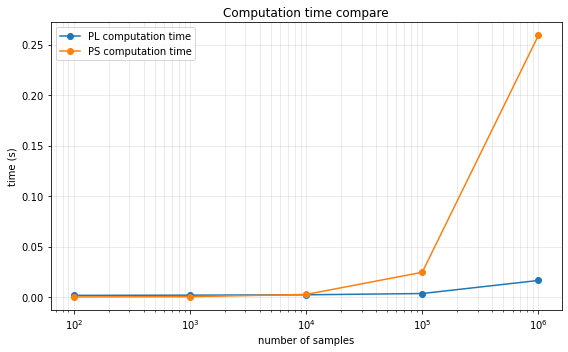

In [177]:
# Jupyter 單格版：只量三維 norm 計算時間，並畫圖（可選擇存檔）
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
import csv
import time

# 參數區（自己改）
sample_sizes = [100,1000,10000,100000,1000000]
LOW, HIGH = -128, 128
REPEAT = 10            # 每個樣本數重複量測次數，取平均
SEED = 12345          # 基礎亂數種子（會加上重複次數索引）
LOGX = True          # True 就用對數 X 軸
DO_SAVE = True       # True 就存 PNG 與 CSV
PNG_PATH = "norm_time.png"
CSV_PATH = "norm_time.csv"

# 可選：避免中文標籤亂碼（若系統沒有對應字型就改用英文標籤）
import matplotlib

def time_norm_once(n_samples: int, low: int, high: int, seed: int | None = None):
    rng = np.random.default_rng(seed)
    input_array = rng.integers(low, high, size=n_samples*4+12, dtype=np.int16).astype(np.uint16)
    groups = input_array.reshape(-1, 4).astype(np.int64)
    packed_u64 = (groups[:, 3] << 48) | (groups[:, 2] << 32) | (groups[:, 1] << 16) | groups[:, 0]
    a = input_array[12:].reshape(-1, 4).astype(np.int16)
    b = input_array[:12].reshape(3, 4).astype(np.int16).T

    t0 = time.perf_counter()
    PS = a @ b
    PS_result = np.linalg.norm(PS.reshape(-1, 3), axis=1)
    t1 = time.perf_counter()
    PL_result = alu(packed_u64)
    t2 = time.perf_counter()
    return t1 - t0, t2 - t1

# 量測
n_list, g_list, t1_list, t2_list = [], [], [], []
for idx, n in enumerate(sample_sizes):
    acc1 = 0.0
    acc2 = 0.0
    g_keep = None
    for r in range(REPEAT):
        t1, t2 = time_norm_once(n, LOW, HIGH, seed=SEED + r)
        acc1 += t1
        acc2 += t2
    n_list.append(n)
    t1_list.append(acc1 / REPEAT)
    t2_list.append(acc2 / REPEAT)

# 可選：存檔
if DO_SAVE:
    plt.figure(figsize=(8, 5))
    plt.plot(n_list, t2_list, marker="o", linestyle="-", label="PL computation time")
    plt.plot(n_list, t1_list, marker="o", linestyle="-", label="PS computation time")
    if LOGX:
        plt.xscale("log")
    plt.xlabel("number of samples")
    plt.ylabel("time (s)")
    plt.title("Computation time compare")
    plt.grid(True, which="both", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(PNG_PATH, dpi=150)
    with open(CSV_PATH, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["n_samples", "PL_time_s", "PS_time_s"])
        for n, t1, t2 in zip(n_list, t1_list, t2_list):
            writer.writerow([n, f"{t1:.9f}", f"{t2:.9f}"])
    print(f"已存圖檔: {PNG_PATH}")
    print(f"已存 CSV: {CSV_PATH}")

In [178]:
t2_list

[0.0016970910000054574,
 0.0019166859999131703,
 0.0022577599998840014,
 0.0035303460000250197,
 0.016458752999915303]

In [179]:
t1_list

[0.0001589139998941391,
 0.0003887010001562885,
 0.0026233570001750195,
 0.024562847000015608,
 0.2590209940002751]